In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

/home/ezgi/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [37]:
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from keras import optimizers
from keras import initializers
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D


In [3]:
from dreamUtils import *

## Data Load 

In [4]:
locs_3D = sio.loadmat('./data/channelcoords.mat')['locstemp']

In [5]:
type(locs_3D)

numpy.ndarray

In [6]:
single_trial = (sio.loadmat('./data/JL02trial_1.mat')['a_trial']).T
single_trial.shape

(60003, 257)

In [7]:
#take last 20 seconds and 256 electrodes
#referecence electrode is excluded
single_trial = single_trial[-10000:,0:256]
single_trial.shape


(10000, 256)

In [8]:
#random labels for test purpose
single_trial_labels = np.random.randint(3, size= single_trial.shape[0])
single_trial_labels.shape

(10000,)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(single_trial, single_trial_labels, \
                                                    test_size=0.2, random_state=1453)

In [10]:
# encode labels as one-hot vectors
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

In [11]:
locs_2D = map_to_2d(locs_3D)
images = gen_images(locs_2D, X_train[:100,:] , 32, normalize=False,
               augment=False, pca=False, std_mult=0.1, n_components=2, edgeless=False)

## Simple NN

In [56]:
# TWO HIDDEN LAYER NN 

model = Sequential()
# first layer
model.add(Dense(128,   # or 100
                input_dim=256, 
                kernel_initializer='normal',   # 'normal', initializers.Constant(value=0), ...
#                 kernel_regularizer=regularizers.l2(0.01),  # smooth filters, but bad accuracy
                activation='sigmoid'))  # 'relu', 'sigmoid', 'tanh', ...
# second layer
model.add(Dense(32, 
                kernel_initializer='normal',   # 'normal', ...
#                 kernel_regularizer=regularizers.l2(0.1),  # smooth filters, but bad accuracy
                activation='sigmoid'))
# third layer
model.add(Dense(8, 
                kernel_initializer='normal',   # 'normal', ...
#                 kernel_regularizer=regularizers.l2(0.1),  # smooth filters, but bad accuracy
                activation='sigmoid'))

# last layer
model.add(Dense(3, 
                kernel_initializer='normal',   # 'normal', ...
#                 kernel_regularizer=regularizers.l2(0.1),  # smooth filters, but bad accuracy
                activation='softmax'))


# compile
model.compile(loss='categorical_crossentropy',
              optimizer='adam', # 'adam', optimizers.SGD(lr=0.1), ...
              metrics=['accuracy'])

In [60]:
# model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=10, verbose=2)
# scores = model.evaluate(X_test, y_test, verbose=0)
# print("Baseline Error: %.2f%%" % (100-scores[1]*100))

## Simple CNN  (for 16x16 EEG images)¶

In [ ]:
X_train_16 = X_train.reshape(-1,16,16,1)
X_test_16 = X_test.reshape(-1,16,16,1)

In [ ]:
X_train_16.shape

In [ ]:
# create model
model = Sequential()
# add layers
model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(16,16,1)))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))

In [ ]:
# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# train the model
#model.fit(X_train_16, y_train, validation_data=(X_test_16, y_test), epochs=10)

## Simple CNN (AEP for 32x32 images)
### Architecture D (Bashivan2016)

In [12]:
# AEP map of electrodes from 3D to 2D space 
locs_2D = map_to_2d(locs_3D)
# Generate single-channel train images
train_images = gen_images(locs_2D, X_train , 32, normalize=False,
                augment=False, pca=False, std_mult=0.1, n_components=2, edgeless=False)
# Generate single-channel test images
test_images = gen_images(locs_2D, X_test , 32, normalize=False,
                augment=False, pca=False, std_mult=0.1, n_components=2, edgeless=False)



Interpolated 2000/2000

In [13]:
train_images.shape

(8000, 1, 32, 32)

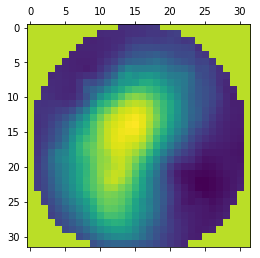

In [14]:
plt.matshow(train_images[5].reshape(32,32))

In [15]:
#check how transpose function works
#deneme = np.transpose(train_images, (0,2,3,1))

In [33]:
#correct input shape before feeding to CNN
X_train_32 = train_images.reshape(-1,32,32,1)
X_test_32 = test_images.reshape(-1,32,32,1)

In [44]:
# create model
model = Sequential()
# add layers
# activation is NONE  #model.add(Conv2D(32, kernel_size=3, activation='relu'))

model.add(Conv2D(32, kernel_size=3, input_shape=(32,32,1), kernel_initializer='glorot_uniform'))
model.add(Conv2D(32, kernel_size=3, padding='same', kernel_initializer='glorot_uniform'))
model.add(Conv2D(32, kernel_size=3, padding='same', kernel_initializer='glorot_uniform'))
model.add(Conv2D(32, kernel_size=3, padding='same', kernel_initializer='glorot_uniform'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_last'))
# after max-pooling
model.add(Conv2D(64, kernel_size=3, padding='same', kernel_initializer='glorot_uniform'))
model.add(Conv2D(64, kernel_size=3, padding='same', kernel_initializer='glorot_uniform'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_last'))
# another max-pooling
model.add(Conv2D(128, kernel_size=3, padding='same', kernel_initializer='glorot_uniform'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_last'))
# fully connected layer
model.add(Flatten())
model.add(Dense(512))
model.add(Dense(3, activation='softmax'))

In [45]:
# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [47]:
# train the model
#model.fit(X_train_32, y_train, validation_data=(X_test_32, y_test), epochs=10)

## Simple CNN (AEP for 32x32 images - Multichannel)

In [48]:
## format data in correct manner



In [ ]:
# create model
model = Sequential()
# add layers
# activation is NONE  #model.add(Conv2D(32, kernel_size=3, activation='relu'))

model.add(Conv2D(32, kernel_size=3, input_shape=(32,32,1), kernel_initializer='glorot_uniform'))
model.add(Conv2D(32, kernel_size=3, padding='same', kernel_initializer='glorot_uniform'))
model.add(Conv2D(32, kernel_size=3, padding='same', kernel_initializer='glorot_uniform'))
model.add(Conv2D(32, kernel_size=3, padding='same', kernel_initializer='glorot_uniform'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_last'))
# after max-pooling
model.add(Conv2D(64, kernel_size=3, padding='same', kernel_initializer='glorot_uniform'))
model.add(Conv2D(64, kernel_size=3, padding='same', kernel_initializer='glorot_uniform'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_last'))
# another max-pooling
model.add(Conv2D(128, kernel_size=3, padding='same', kernel_initializer='glorot_uniform'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_last'))
# fully connected layer
model.add(Flatten())
model.add(Dense(512))
model.add(Dense(3, activation='softmax'))

In [ ]:
# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# train the model
#model.fit(X_train_32, y_train, validation_data=(X_test_32, y_test), epochs=10)

## Simple CNN (for Tx32x32 EEG Videos)

In [22]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution3D, MaxPooling3D
from keras.optimizers import SGD, RMSprop
from keras.utils import np_utils, generic_utils
import theano
import cv2 as cv
from keras.layers import Conv3D

In [25]:
X_train_32.shape

(8000, 32, 32, 1)

In [ ]:
X_train_v.shape

In [27]:
# how many frame a video will consist
#####TODO: do not forget to divide labels
def divide_into_timeslots(time_slot, data):
    data_list = []
    for t in range(int(data.shape[0]/time_slot)):
        data_list.append(data[t * time_slot:(t + 1) * time_slot,:,:,:])

    return np.asarray(data_list)

In [28]:
X_train_v_100 = divide_into_timeslots(time_slot= 10, data= X_train_32)
X_test_v_100 =  divide_into_timeslots(time_slot= 10, data= X_test_32)

In [29]:
X_train_v_100.shape

(800, 10, 32, 32, 1)

In [52]:
# create model
model = Sequential()
# add layers
model.add(Conv3D(32, kernel_size=3, input_shape=(10,32,32,1)))
model.add(Conv3D(32, kernel_size=3, strides=(1,1,1), dilation_rate=(1,1,1), padding='same' ))
model.add(Conv3D(32, kernel_size=3, strides=(1,1,1), dilation_rate=(1,1,1), padding='same' ))
model.add(Conv3D(32, kernel_size=3, strides=(1,1,1), dilation_rate=(1,1,1), padding='same' ))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=None, padding='valid', data_format='channels_last'))
# new layer
model.add(Conv3D(64, kernel_size=3, strides=(1,1,1), dilation_rate=(1,1,1), padding='same' ))
model.add(Conv3D(64, kernel_size=3, strides=(1,1,1), dilation_rate=(1,1,1), padding='same' ))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=None, padding='valid', data_format='channels_last'))
# flatten and check
model.add(Flatten())
model.add(Dense(128))
model.add(Dense(3, activation='softmax'))

In [53]:
# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [55]:
#train the model
#model.fit(X_train_v_100,y_train[:800], validation_data=(X_test_v_100, y_test[:200]), epochs=1)

## Simple CNN (for Tx32x32 EEG Videos - Multichannel)

In [ ]:
# DO NOT FORGET TO CHANGE DATA FORMAT

In [ ]:
# create model
model = Sequential()
# add layers
model.add(Conv3D(32, kernel_size=3, input_shape=(10,32,32,2)))
model.add(Conv3D(32, kernel_size=3, strides=(1,1,1), dilation_rate=(1,1,1), padding='same' ))
model.add(Conv3D(32, kernel_size=3, strides=(1,1,1), dilation_rate=(1,1,1), padding='same' ))
model.add(Conv3D(32, kernel_size=3, strides=(1,1,1), dilation_rate=(1,1,1), padding='same' ))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=None, padding='valid', data_format='channels_last'))
# new layer
model.add(Conv3D(64, kernel_size=3, strides=(1,1,1), dilation_rate=(1,1,1), padding='same' ))
model.add(Conv3D(64, kernel_size=3, strides=(1,1,1), dilation_rate=(1,1,1), padding='same' ))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=None, padding='valid', data_format='channels_last'))
# flatten and check
model.add(Flatten())
model.add(Dense(128))
model.add(Dense(3, activation='softmax'))

In [ ]:
# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#train the model
#model.fit(X_train_v_100,y_train[:800], validation_data=(X_test_v_100, y_test[:200]), epochs=1)

## ConvNet+LSTM (Bashivan2016)

## ConvNet+LSTM/1D-Conv(Bashivan2016)